In [12]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, applications, optimizers, regularizers
from tensorflow.keras.callbacks import (EarlyStopping, ModelCheckpoint,
                                        ReduceLROnPlateau, TensorBoard)
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from mtcnn import MTCNN  # MTCNN face detector

In [ ]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 50
FRAMES_PER_VIDEO = 30
RANDOM_STATE = 42
MODEL_PATH = 'anti_spoofing_enhanced_1.h5'

dataset_path = 'anti-spoofing_data'
assert os.path.exists(dataset_path), f"Dataset path {dataset_path} không tồn tại"

In [3]:
detector = MTCNN()

def preprocess_image(frame):
    # Phát hiện mặt và crop
    faces = detector.detect_faces(frame)
    if faces:
        x, y, w, h = faces[0]['box']
        face = frame[y:y+h, x:x+w]
    else:
        face = frame
    face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
    face = cv2.resize(face, IMAGE_SIZE)
    face = face / 255.0
    return face

In [4]:
categories = ["live_selfie", "live_video", "cut-out printouts", "printouts", "replay"]
real_cats = ["live_selfie", "live_video"]

X, binary_y = [], []
for cat in categories:
    folder = os.path.join(dataset_path, cat)
    label = 0 if cat in real_cats else 1
    for vid in os.listdir(folder):
        path = os.path.join(folder, vid)
        cap = cv2.VideoCapture(path)
        total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        idxs = np.linspace(0, total-1, min(FRAMES_PER_VIDEO, total)).astype(int)
        for i in idxs:
            cap.set(cv2.CAP_PROP_POS_FRAMES, i)
            ret, frm = cap.read()
            if not ret: continue
            img = preprocess_image(frm)
            X.append(img)
            binary_y.append(label)
        cap.release()

X = np.array(X, dtype=np.float32)
y = np.array(binary_y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

In [6]:
augmentation_layers = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
    layers.RandomTranslation(0.1, 0.1)
])

def augment(image, label):
    return augmentation_layers(image), label

In [7]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))\
              .shuffle(1024)\
              .map(augment, num_parallel_calls=tf.data.AUTOTUNE)\
              .batch(BATCH_SIZE)\
              .prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))\
             .batch(BATCH_SIZE)

In [8]:
import tensorflow.keras.backend as K

def focal_loss(gamma=2., alpha=.25):
    def loss(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1-K.epsilon())
        p_t = tf.where(K.equal(y_true, 1), y_pred, 1-y_pred)
        alpha_factor = K.ones_like(y_true) * alpha
        alpha_t = tf.where(K.equal(y_true, 1), alpha_factor, 1-alpha_factor)
        return -K.mean(alpha_t * K.pow((1 - p_t), gamma) * K.log(p_t))
    return loss

In [9]:
from tensorflow.keras import regularizers

def create_finetune_model():
    base = applications.MobileNetV2(
        weights='imagenet', include_top=False, input_shape=(*IMAGE_SIZE,3)
    )
    for layer in base.layers[:-50]: layer.trainable = False
    for layer in base.layers[-50:]: layer.trainable = True

    x = layers.GlobalAveragePooling2D()(base.output)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.Dropout(0.6)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.Dropout(0.4)(x)
    x = layers.BatchNormalization()(x)
    out = layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs=base.input, outputs=out)
    optimizer = optimizers.Adam(learning_rate=5e-5)
    model.compile(optimizer=optimizer,
                  loss=focal_loss(alpha=0.25, gamma=2.0),
                  metrics=['accuracy'])
    return model

model = create_finetune_model()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃  Param # ┃ Connected to    ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1     │ (None, 224,     │        0 │ -               │
│ (InputLayer)      │ 224, 3)         │          │                 │
├───────────────────┼─────────────────┼──────────┼─────────────────┤
│ Conv1 (Conv2D)    │ (None, 112,     │      864 │ input_layer_1[… │
│                   │ 112, 32)        │          │                 │
├───────────────────┼─────────────────┼──────────┼─────────────────┤
│ bn_Conv1          │ (None, 112,     │      128 │ Conv1[0][0]     │
│ (BatchNormalizat… │ 112, 32)        │          │                 │
├───────────────────┼─────────────────┼──────────┼─────────────────┤
│ Conv1_relu (ReLU) │ (None, 112,     │        0 │ bn_Conv1[0][0]  │
│                   │ 112, 32)        │          │                 │
├───────────────────┼─────────────────┼──────────┼─────────────────┤
│ expanded_conv_de… │ (None, 112,     │      288 │ Conv1_relu[0][… │
│ (DepthwiseConv2D) │ 112, 32)        │          │                 │
├───────────────────┼─────────────────┼──────────┼─────────────────┤
│ expanded_conv_de… │ (None, 112,     │      128 │ expanded_conv_… │
│ (BatchNormalizat… │ 112, 32)        │          │                 │
├───────────────────┼─────────────────┼──────────┼─────────────────┤
│ expanded_conv_de… │ (None, 112,     │        0 │ expanded_conv_… │
│ (ReLU)            │ 112, 32)        │          │                 │
├───────────────────┼─────────────────┼──────────┼─────────────────┤
│ expanded_conv_pr… │ (None, 112,     │      512 │ expanded_conv_… │
│ (Conv2D)          │ 112, 16)        │          │                 │
├───────────────────┼─────────────────┼──────────┼─────────────────┤
│ expanded_conv_pr… │ (None, 112,     │       64 │ expanded_conv_… │
│ (BatchNormalizat… │ 112, 16)        │          │                 │
├───────────────────┼─────────────────┼──────────┼─────────────────┤
│ block_1_expand    │ (None, 112,     │    1,536 │ expanded_conv_… │
│ (Conv2D)          │ 112, 96)        │          │                 │
├───────────────────┼─────────────────┼──────────┼─────────────────┤
│ block_1_expand_BN │ (None, 112,     │      384 │ block_1_expand… │
│ (BatchNormalizat… │ 112, 96)        │          │                 │
├───────────────────┼─────────────────┼──────────┼─────────────────┤
│ block_1_expand_r… │ (None, 112,     │        0 │ block_1_expand… │
│ (ReLU)            │ 112, 96)        │          │                 │
├───────────────────┼─────────────────┼──────────┼─────────────────┤
│ block_1_pad       │ (None, 113,     │        0 │ block_1_expand… │
│ (ZeroPadding2D)   │ 113, 96)        │          │                 │
├───────────────────┼─────────────────┼──────────┼─────────────────┤
│ block_1_depthwise │ (None, 56, 56,  │      864 │ block_1_pad[0]… │
│ (DepthwiseConv2D) │ 96)             │          │                 │
├───────────────────┼─────────────────┼──────────┼─────────────────┤
│ block_1_depthwis… │ (None, 56, 56,  │      384 │ block_1_depthw… │
│ (BatchNormalizat… │ 96)             │          │                 │
├───────────────────┼─────────────────┼──────────┼─────────────────┤
│ block_1_depthwis… │ (None, 56, 56,  │        0 │ block_1_depthw… │
│ (ReLU)            │ 96)             │          │                 │
├───────────────────┼─────────────────┼──────────┼─────────────────┤
│ block_1_project   │ (None, 56, 56,  │    2,304 │ block_1_depthw… │
│ (Conv2D)          │ 24)             │          │                 │
├───────────────────┼─────────────────┼──────────┼─────────────────┤
│ block_1_project_… │ (None, 56, 56,  │       96 │ block_1_projec… │
│ (BatchNormalizat… │ 24)             │          │                 │
├───────────────────┼─────────────────┼──────────┼─────────────────┤
│ block_2_expand    │ (None, 56, 56,  │    3,456 │ block_1_projec… 

 Total params: 2,625,601 (10.02 MB)

 Trainable params: 2,219,393 (8.47 MB)

 Non-trainable params: 406,208 (1.55 MB)

In [10]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7),
    ModelCheckpoint(MODEL_PATH, monitor='val_accuracy', save_best_only=True),
    TensorBoard(log_dir='logs/anti_spoofing_v1')
]

history = model.fit(train_ds, validation_data=test_ds,
                    epochs=EPOCHS, callbacks=callbacks)

Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 549ms/step - accuracy: 0.5337 - loss: 0.2084

28/28 ━━━━━━━━━━━━━━━━━━━━ 31s 699ms/step - accuracy: 0.5340 - loss: 0.2086 - val_accuracy: 0.5780 - val_loss: 0.1268 - learning_rate: 5.0000e-05
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 600ms/step - accuracy: 0.6046 - loss: 0.1966

28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 715ms/step - accuracy: 0.6050 - loss: 0.1964 - val_accuracy: 0.6835 - val_loss: 0.1147 - learning_rate: 5.0000e-05
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 550ms/step - accuracy: 0.6389 - loss: 0.1856

28/28 ━━━━━━━━━━━━━━━━━━━━ 18s 652ms/step - accuracy: 0.6387 - loss: 0.1856 - val_accuracy: 0.7064 - val_loss: 0.1058 - learning_rate: 5.0000e-05
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 539ms/step - accuracy: 0.6551 - loss: 0.1710

28/28 ━━━━━━━━━━━━━━━━━━━━ 18s 639ms/step - accuracy: 0.6558 - loss: 0.1707 - val_accuracy: 0.7339 - val_loss: 0.1016 - learning_rate: 5.0000e-05
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 537ms/step - accuracy: 0.6972 - loss: 0.1429

28/28 ━━━━━━━━━━━━━━━━━━━━ 18s 639ms/step - accuracy: 0.6968 - loss: 0.1429 - val_accuracy: 0.7477 - val_loss: 0.1007 - learning_rate: 5.0000e-05
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 541ms/step - accuracy: 0.7132 - loss: 0.1403

28/28 ━━━━━━━━━━━━━━━━━━━━ 18s 645ms/step - accuracy: 0.7131 - loss: 0.1401 - val_accuracy: 0.7615 - val_loss: 0.0990 - learning_rate: 5.0000e-05
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 18s 632ms/step - accuracy: 0.7164 - loss: 0.1292 - val_accuracy: 0.7569 - val_loss: 0.0971 - learning_rate: 5.0000e-05
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 546ms/step - accuracy: 0.7187 - loss: 0.1359

28/28 ━━━━━━━━━━━━━━━━━━━━ 18s 648ms/step - accuracy: 0.7185 - loss: 0.1360 - val_accuracy: 0.7982 - val_loss: 0.0947 - learning_rate: 5.0000e-05
Epoch 9/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 18s 626ms/step - accuracy: 0.7526 - loss: 0.1187 - val_accuracy: 0.7936 - val_loss: 0.0927 - learning_rate: 5.0000e-05
Epoch 10/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 18s 637ms/step - accuracy: 0.7420 - loss: 0.1333 - val_accuracy: 0.7844 - val_loss: 0.0939 - learning_rate: 5.0000e-05
Epoch 11/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 540ms/step - accuracy: 0.7500 - loss: 0.1340

28/28 ━━━━━━━━━━━━━━━━━━━━ 18s 641ms/step - accuracy: 0.7504 - loss: 0.1337 - val_accuracy: 0.8028 - val_loss: 0.0911 - learning_rate: 5.0000e-05
Epoch 12/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 544ms/step - accuracy: 0.7697 - loss: 0.1215

28/28 ━━━━━━━━━━━━━━━━━━━━ 18s 649ms/step - accuracy: 0.7695 - loss: 0.1215 - val_accuracy: 0.8211 - val_loss: 0.0869 - learning_rate: 5.0000e-05
Epoch 13/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 562ms/step - accuracy: 0.7838 - loss: 0.1128

28/28 ━━━━━━━━━━━━━━━━━━━━ 19s 680ms/step - accuracy: 0.7836 - loss: 0.1129 - val_accuracy: 0.8349 - val_loss: 0.0864 - learning_rate: 5.0000e-05
Epoch 14/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 596ms/step - accuracy: 0.8151 - loss: 0.1055

28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 707ms/step - accuracy: 0.8145 - loss: 0.1057 - val_accuracy: 0.8394 - val_loss: 0.0888 - learning_rate: 5.0000e-05
Epoch 15/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 587ms/step - accuracy: 0.7906 - loss: 0.1205

28/28 ━━━━━━━━━━━━━━━━━━━━ 19s 691ms/step - accuracy: 0.7911 - loss: 0.1202 - val_accuracy: 0.8899 - val_loss: 0.0827 - learning_rate: 5.0000e-05
Epoch 16/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 18s 637ms/step - accuracy: 0.8047 - loss: 0.1024 - val_accuracy: 0.8853 - val_loss: 0.0820 - learning_rate: 5.0000e-05
Epoch 17/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 19s 672ms/step - accuracy: 0.8169 - loss: 0.1037 - val_accuracy: 0.8899 - val_loss: 0.0791 - learning_rate: 5.0000e-05
Epoch 18/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 539ms/step - accuracy: 0.8195 - loss: 0.1009

28/28 ━━━━━━━━━━━━━━━━━━━━ 18s 652ms/step - accuracy: 0.8194 - loss: 0.1010 - val_accuracy: 0.8945 - val_loss: 0.0808 - learning_rate: 5.0000e-05
Epoch 19/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - accuracy: 0.8504 - loss: 0.1015

28/28 ━━━━━━━━━━━━━━━━━━━━ 19s 668ms/step - accuracy: 0.8503 - loss: 0.1014 - val_accuracy: 0.9083 - val_loss: 0.0785 - learning_rate: 5.0000e-05
Epoch 20/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 19s 678ms/step - accuracy: 0.8117 - loss: 0.0996 - val_accuracy: 0.9037 - val_loss: 0.0839 - learning_rate: 5.0000e-05
Epoch 21/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 701ms/step - accuracy: 0.8390 - loss: 0.1003 - val_accuracy: 0.8945 - val_loss: 0.0835 - learning_rate: 5.0000e-05
Epoch 22/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 589ms/step - accuracy: 0.8637 - loss: 0.0911

28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 705ms/step - accuracy: 0.8636 - loss: 0.0911 - val_accuracy: 0.9128 - val_loss: 0.0764 - learning_rate: 5.0000e-05
Epoch 23/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 593ms/step - accuracy: 0.8801 - loss: 0.0866

28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 708ms/step - accuracy: 0.8795 - loss: 0.0867 - val_accuracy: 0.9174 - val_loss: 0.0746 - learning_rate: 5.0000e-05
Epoch 24/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 640ms/step - accuracy: 0.8513 - loss: 0.0926

28/28 ━━━━━━━━━━━━━━━━━━━━ 21s 757ms/step - accuracy: 0.8517 - loss: 0.0925 - val_accuracy: 0.9312 - val_loss: 0.0747 - learning_rate: 5.0000e-05
Epoch 25/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 562ms/step - accuracy: 0.8322 - loss: 0.0931

28/28 ━━━━━━━━━━━━━━━━━━━━ 19s 673ms/step - accuracy: 0.8328 - loss: 0.0930 - val_accuracy: 0.9358 - val_loss: 0.0754 - learning_rate: 5.0000e-05
Epoch 26/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 19s 674ms/step - accuracy: 0.8809 - loss: 0.0884 - val_accuracy: 0.9358 - val_loss: 0.0730 - learning_rate: 5.0000e-05
Epoch 27/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 19s 692ms/step - accuracy: 0.8929 - loss: 0.0822 - val_accuracy: 0.9358 - val_loss: 0.0738 - learning_rate: 5.0000e-05
Epoch 28/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 598ms/step - accuracy: 0.9033 - loss: 0.0921

28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 707ms/step - accuracy: 0.9027 - loss: 0.0919 - val_accuracy: 0.9404 - val_loss: 0.0726 - learning_rate: 5.0000e-05
Epoch 29/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 19s 684ms/step - accuracy: 0.8740 - loss: 0.0875 - val_accuracy: 0.9404 - val_loss: 0.0725 - learning_rate: 5.0000e-05
Epoch 30/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 19s 679ms/step - accuracy: 0.9175 - loss: 0.0802 - val_accuracy: 0.9404 - val_loss: 0.0720 - learning_rate: 5.0000e-05
Epoch 31/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 720ms/step - accuracy: 0.8909 - loss: 0.0838 - val_accuracy: 0.9358 - val_loss: 0.0702 - learning_rate: 5.0000e-05
Epoch 32/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 705ms/step - accuracy: 0.8995 - loss: 0.0852 - val_accuracy: 0.9404 - val_loss: 0.0688 - learning_rate: 5.0000e-05
Epoch 33/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 611ms/step - accuracy: 0.8798 - loss: 0.0822

28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 725ms/step - accuracy: 0.8802 - loss: 0.0822 - val_accuracy: 0.9679 - val_loss: 0.0741 - learning_rate: 5.0000e-05
Epoch 34/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 699ms/step - accuracy: 0.8996 - loss: 0.0802 - val_accuracy: 0.9679 - val_loss: 0.0724 - learning_rate: 5.0000e-05
Epoch 35/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 19s 674ms/step - accuracy: 0.8911 - loss: 0.0957 - val_accuracy: 0.9679 - val_loss: 0.0752 - learning_rate: 5.0000e-05


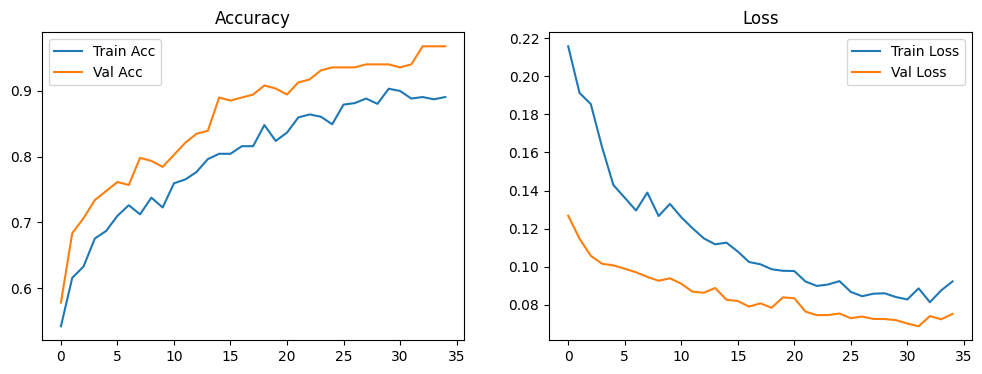

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 417ms/step


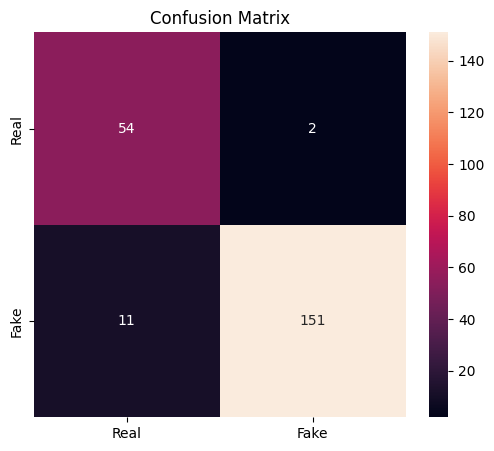

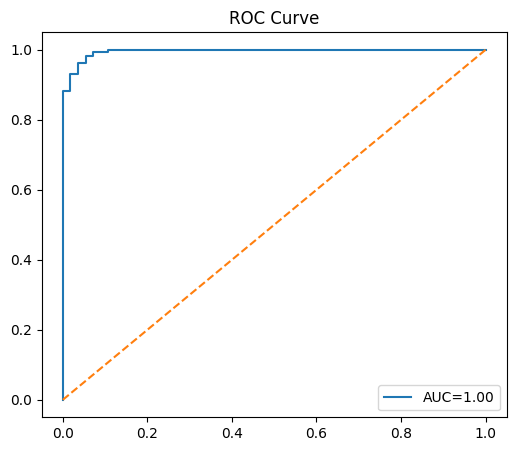

Classification Report:
              precision    recall  f1-score   support

        Real       0.83      0.96      0.89        56
        Fake       0.99      0.93      0.96       162

    accuracy                           0.94       218
   macro avg       0.91      0.95      0.93       218
weighted avg       0.95      0.94      0.94       218



In [13]:
# Cell 10: Đánh giá và visualization
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend(); plt.title('Accuracy')
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title('Loss')
plt.show()

y_score = model.predict(X_test).ravel()
y_pred = (y_score > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=['Real','Fake'],
            yticklabels=['Real','Fake'])
plt.title('Confusion Matrix'); plt.show()

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC={roc_auc:.2f}')
plt.plot([0,1],[0,1],'--'); plt.title('ROC Curve'); plt.legend(); plt.show()

print('Classification Report:')
print(classification_report(y_test, y_pred, target_names=['Real','Fake']))

In [14]:
model.save(MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")
loaded = keras.models.load_model(MODEL_PATH, compile=False)
print("Model loaded successfully")

Model saved to anti_spoofing_enhanced_1.h5
Model loaded successfully
